# Description
This script can be used for an optimization with an cylinder as an initial geometry. The diameter from the cylinder is fixed.

In [1]:
# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import *
from matplotlib.widgets import Slider

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ddgclib._catenoid import *
from ddgclib._truncated_cone import *
from ddgclib._plotting import *

from timeit import default_timer as timer


def curvature(v):
    F, nn = vectorise_vnn(v)
    curvature_dict = b_curvatures_hn_ij_c_ij(F, nn)
    #curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    #N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]]) # Version from Stefan
    #N_f0 = normalized(N_f0)[0]
    #curvature_dict = b_curvatures_hn_ij_c_ij(F, nn, n_i = N_f0)
    HNdA_i = curvature_dict['HNdA_i']
    return HNdA_i

'''
            for v in HC.V:
                #TODO: REMOVE UNDER NORMAL CONDITIONS:
                if 0: # boolean operatore for =false
                    if v in bV:
                        continue
                N_f0 = np.array(
                    [0.0, 0.0, R * np.sin(theta_p)]) - v.x_a  # First approximation
                # for bridges this should be something like:
                # N_f0 = v.x_a - np.array([v.x_a[0], v.x_a[1], 0.0])
                N_f0 = normalized(N_f0)[0]
                N_i.append(N_f0)
                F, nn = vectorise_vnn(v)
                # Compute discrete curvatures
                c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i=N_f0) # curvature_dict - calculating the curvature at the vertex v
'''


def b_disc_angle(v, r, print_out=True):
    """
    Takes boundary vertex v and outputs the contact angle

    v: vertex
    N: normal vector estimating the direction of the surface (liquid to gas)
    """

    #N_i = []  # Temp cap rise normal

    # -------------
    angle_list = []
    #N_f0 = v.x_a - np.array([v.x_a[0], v.x_a[1], 0.0])
    N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]]) # Version from Stefan

    #        N_f0 = np.array([0.0, 0.0, R * np.sin(theta_p)]) - v.x_a  # First approximation
    N_f0 = -normalized(N_f0)[0]
    #N_i.append(N_f0)
    #print(f'N_f0 = {N_f0}')
    F, nn = vectorise_vnn(v)
   # c_outd = b_curvatures_hn_ij_c_ij_play(F, nn, n_i = N_f0)
    c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i = N_f0)
   # c_outd = b_curvatures_hn_ij_c_ij_play(F, nn)
    # --------------------

    # Compute the curvature and the dual areas
    #F, nn = vectorise_vnn(v)
    #c_outd = b_curvatures_hn_ij_c_ij_play(F, nn)

    K_H_i = c_outd['K_H_i']


    #TODO: Adjust for other geometric approximations:
    #l_a = 2 * np.pi * r / len(bV)  # arc length
    Xi = 1
    # Gauss-Bonnet: int_M K dA + int_dM kg ds = 2 pi Xi
    # NOTE: Area should be height of spherical cap    # h = R - r * 4np.tan(theta_p)
    # Approximate radius of the great shpere K = (1/R)**2:
    #r =  #TODO: test if this is a good approximation
    R_approx = 1 / np.sqrt(K_H_i)
    theta_p_approx = np.arccos(np.min([r / R_approx, 1]))
    h = R_approx - r * np.tan(theta_p_approx)
    A_approx = 2 * np.pi * R_approx * h  # Area of spherical cap

    # A_approx  # Approximate area of the spherical cap
    kg_ds = 2 * np.pi * Xi - K_H_i * (A_approx)
    ds = 2 * np.pi * r  # Arc length of whole spherical cap
    k_g = kg_ds / ds  # / 2.0
    phi_est = np.arctan(R_approx * k_g)

    if print_out:
        print(f'theta_p_approx = {theta_p_approx * 180 / np.pi}')
       # print(f'cos = {[r / R_approx]}')

    return phi_est




def b_force(v, theta_p, print_out=True):
    """
    The force on the three-phase contact angle
    Theta_i: Estimated sector angle of vertex i
    theta_p: Equilibrium three-phase contact angle
    """


    phi_est, l_a = b_disc_angle(v)
    # Compute boundary forces
    # N m-1
    gamma_bt = gamma * (np.cos(phi_est)
                        - np.cos(theta_p)) * np.array([0, 0, 1.0])

    if print_out:
        print(f'phi_est  = {phi_est * 180 / np.pi}')
        #print(f'dK[i] = {dK[i]}')
    return gamma_bt


def b_move_vertex(v, Theta_i, theta_p, print_out=True):
    """
    Move the boundary vertex
    """

    F_bt = gamma_bt * l_a  # N
    new_vx = v.x + 1e-1 * F_bt
    new_vx = tuple(new_vx)
    HC.V.move(v, new_vx)
    bV_new.add(HC.V[new_vx])




In [2]:
'''
in this part of the code, the boundarys will be closed with the function close_boundary.

'''
def close_boundary(HC, boundary_top, boundary_bottom):
    v_avg_top = np.zeros(3)
    for v in boundary_top:
        v_avg_top += v.x_a

    v_avg_top = v_avg_top/len(boundary_top)
    v_avg_bottom = np.zeros(3)
    for v in boundary_bottom:
        v_avg_bottom += v.x_a

    v_avg_bottom = v_avg_bottom/len(boundary_bottom)

    vat = HC.V[tuple(v_avg_top)]
    for v in boundary_top:
        v.connect(vat)

    vab = HC.V[tuple(v_avg_bottom)]
    for v in boundary_bottom:
        v.connect(vab)

#    boundary_top.add(vat) # from stefan
#    boundary_bottom.add(vab) # from stefan

    boundary_top.append(vat)
    boundary_bottom.append(vab)
    return HC, boundary_top, boundary_bottom

In [3]:
'''
Function for calculating the volume of the mesh
'''
def volume(v):
    F, nn = vectorise_vnn(v)
    curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    #print(curvature_dict)
    V_ijk = curvature_dict['V_ijk']
    N_i = curvature_dict['N_i']
    #print(N_i)
    return V_ijk


'''
V = 0
for v in HC.V:
    V_ijk = volume(v)
    #print(V_ijk)
    V += np.sum(V_ijk)

V = V/12
'''

'\nV = 0\nfor v in HC.V:\n    V_ijk = volume(v)\n    #print(V_ijk)\n    V += np.sum(V_ijk)\n\nV = V/12\n'

# Functions

In [4]:

def fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_c, tau, gamma, breaking_condition, itermax):
    '''
    length = length of the inital cone
    tau = size of time step
    t_f = breaking condition in the while-loop = last time step
    d = diameter of the initial cyliner
    '''
    starttime = timer()
    print('Simulation is started!')
    print('-------------------------------------')


    '''
    -----------------------------------------------------------
    From here, the mesh for an open truncated cone is meshed
    '''
    r_l = d_l / 2
    r_u = d_u / 2



    v_l = 0
    v_u = length +v_l

    r_approx = length/2.0  # approximate radius of the contact angle spherical cap
    '''
    -----------------------------------------------------------
    From here, the mesh for an open truncated cone is meshed
    '''

    HC, bV, K_f, H_f, neck_verts, neck_sols = truncated_cone_initial_N(r_l, r_u, length, refinement)

    '''
    -----------------------------------------------------------
    closing the open mesh
    '''



    # Define bottom boundary condition
    boundary_bottom = []
    for v in HC.V:
        #if v.x[2] == v_l:
        #if v.x[2] >= v_l - 1e-5 and v.x[2] <= v_l + 1e-5 or v.x[2] == v_l:
        if v.x[2] == v_l:
          #  print(f'v.x bottom ={v.x}')
            boundary_bottom.append(v)

    # Define top boundary condition
    boundary_top = []
    for v in HC.V:
        #if v.x[2] == v_u:
        #if v.x[2] >= v_u - 1e-5 and v.x[2] <= v_u + 1e-5 or v.x[2] == v_u:
        if v.x[2] == v_u:
           # print(f'v.x top ={v.x}')
            boundary_top.append(v)

   # HC, boundary_top, boundary_bottom = close_boundary(HC, boundary_top, boundary_bottom)
    '''
    ----------------------------------------------------
    Dummy parameter for the residual
    '''
    # runvariable for the iteration tracking
    residual_iteration = 0
    iteration_list = []

    # list to track the progress from df
    df_list_max = []
    df_list_min = []

    # list to track the progress of HNdA
    dHNdA_list_min = []
    dHNdA_list_max = []

    res_list = []

    volume_list = []



    '''
    -----------------------------------------------------------
    From here, the optimization is started
    '''

    iters = 0



    while True:

        if itermax == 0:
            print('Mesh is generated. Optimization was not carried out because itermax = 0.')

            break

        if iters > itermax:
            endtime = timer()
            print('-------------------------------------')
            print("Too many iterations! Simulation is canceled!")
            print(f"Time elapsed for canceled Simulation: {endtime-starttime:.2f} s")

            break

        # Loop through all interior vertices
        # calculating the volume of the entire bridge
        '''
        New Part Starting 1  ------------------------
        '''
        V_current = 0
        number_v = 0


        for v in HC.V:
            number_v += 1

            V_ijk = volume(v)
            #print(V_ijk)
            V_current += np.sum(V_ijk)

        V_current = V_current/12

        volume_list.append(V_current)


        cHCV = copy.copy(HC.V)

        # dummy list to find the maximum df
        df_list_dummy       = []
        dHNdA_list_dummy    = []
        v_boundary_interior = {}


        '''
        Start boundary conditions ----------------------------------------------------------------------------------------------------------------- Start BC
        '''


        print(f'number of vertexes = {number_v}')
        for v in cHCV:

            # exclude boundaries
            if v in set(boundary_bottom):
                #continue
                #Theta_i = 2 * np.pi / len(boundary_bottom)
               # print('.')
               # print(f'Boundary bottom:')
                phi_est = b_disc_angle(v, r=r_approx, print_out=True)
                print(f'phi_est radian = {phi_est}')
                print(f'phi_est gradient = {phi_est * np.pi/180.0}')
                #gamma_bt
                for vnn in v.nn:
                    if (vnn in boundary_bottom): # or (vnn in boundary_top):
                        continue
                    else:
                        vnn_factor = phi_est - theta_c
                        # vnn_factor = theta_c - phi_est
                        try:
                            v_boundary_interior[vnn.x] += vnn_factor
                        except KeyError:
                            v_boundary_interior[vnn.x] = vnn_factor

                continue

            # Define top boundary condition


            if v in set(boundary_top):

                #Theta_i = 2 * np.pi / len(boundary_top)
                #print('.')
                #print(f'Boundary top:')
                phi_est = b_disc_angle(v, r=r_approx, print_out=False)
                for vnn in v.nn:
                    #if (vnn in boundary_bottom) or (vnn in boundary_top):
                    if (vnn in boundary_top): # or (vnn in boundary_bottom)
                        continue
                    else:
                        vnn_factor = phi_est - theta_c
                       # vnn_factor = theta_c - phi_est
                        try:
                            v_boundary_interior[vnn.x] += vnn_factor
                        except KeyError:
                            v_boundary_interior[vnn.x] = vnn_factor

                continue


            '''
            End boundary conditions ----------------------------------------------------------------------------------------------------------------- end BC
            '''
            # Compute curvature for each interior vertex
            HNdA_i = curvature(v)

            # Enforce boundary contact angle
            db = np.zeros_like(HNdA_i)

           # print(f'v_boundary_interior = {v_boundary_interior}')
            if v.x in v_boundary_interior.keys():

                #db = 1e-1 * tau * v_boundary_interior[v.x] * HNdA_i#  normalized(HNdA_i)[0]
                db = tau * v_boundary_interior[v.x] * HNdA_i#  normalized(HNdA_i)[0]
                db[2] = 0

               # print(f'vnn.x = {vnn.x}')
               # print(f'v_boundary_interior[vnn.x] = {v_boundary_interior[vnn.x]}')
              #  print(f'HNdAi = {HNdA_i}')
               # print(f'db = {db}')

            else:
                pass


            # Step in time
            df = - gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)
            #df[1] = 0
            v_new = v.x_a - tau/2 * df + db

            #v_new = v.x_a - tau/2 * df
            HC.V.move(v, tuple(v_new))
            df_list_dummy.append(np.linalg.norm(df))
            dHNdA_list_dummy.append(np.linalg.norm(HNdA_i))

        iters += 1
        # save the maximum and minimum datas for the Residuals
        df_list_max.append(max(df_list_dummy))
        df_list_min.append(min(df_list_dummy))
        # save the numbers of iteration for lately plotting
        iteration_list.append(iters)
        dHNdA_list_max.append(max(dHNdA_list_dummy))
        dHNdA_list_min.append(min(dHNdA_list_dummy))

        #print(iters)
        print(f'number of iteration ={iters}')
       # print(f'len_boundary_bottom = {len(boundary_bottom)}')
       # print(f'boundary_top = {len(boundary_top)}')


        if iters%100 == 0:
            # print(f"Time elapsed: {complex[6]-complex[5]:.2f} s")
            interimstime = timer()
            print(f"Iteration elapsed: {iters:.0f}")
            print(f"Time elapsed:{interimstime-starttime:.2f} s")
            print(f"Amount of highest displacement: {max(df_list_dummy)*10**6:.2f} mikrometer")


        if max(df_list_dummy) < breaking_condition:
            endtime = timer()
            print('-------------------------------------')
            print("Simulation is finished and is terminated without a problem.")
            print(f"Time elapsed for hole Simulation: {endtime-starttime:.2f} s")
            break



    return (HC, iteration_list, df_list_min, df_list_max, volume_list)





In [5]:
#gamma = 728e-6  # N/m, surface tension of water at 20 deg C
gamma = 0.078  # N/m, surface tension of water at 20 deg C
refinement= 3 # NOTE: 2 is the minimum refinement needed for the complex to be manifold
d_l = 0.8e-3 # radian on the lower side of the cone
d_l = 1.6e-3 # radian on the lower side of the cone
d_u = 1.6e-3 # diameter on the upper side of the cone
d_u = 1.6e-3 # diameter on the upper side of the cone
length = 0.7e-3 # length of the cone
#length = 4e-3 # length of the cone
# length = 0.4e-3 # length of the cone
tau = 1e-5    # Endtime for calculation
itermax = 1




# TEST angle:
theta_p = 60 * np.pi/180.0  # Three phase contact angle

'''
t_f = 100 # final time of the time step
V_final = 0.084
damping_factor = 1
'''


breaking_condition = 1e-9

#dummy_parameter = fun_liquid_bridge(-0.5, 0.5,0, 0,1) # v_l, v_u, tau, tf, d
# def fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, volume_constraint)
#fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_c, tau, gamma, breaking_condition, itermax):
# def fun_liquid_bridge_test(d_l, d_u, length, refinement, tau, gamma, breaking_condition,itermax):
dummy_parameter2 = fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_p,tau, gamma, breaking_condition,itermax)

# dummy_parameter = fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, True)

HC = dummy_parameter2[0]
iteration_list = dummy_parameter2[1]
df_list_min = dummy_parameter2[2]
df_list_max = dummy_parameter2[3]
volume_list = dummy_parameter2[4]



Simulation is started!
-------------------------------------
number of vertexes = 136
theta_p_approx = 83.3631524068709
phi_est radian = 1.4549614843417327
phi_est gradient = 0.025393868391467157
theta_p_approx = 83.36315240687085
phi_est radian = 1.454961484341732
phi_est gradient = 0.025393868391467143
theta_p_approx = 83.36315240687087
phi_est radian = 1.4549614843417322
phi_est gradient = 0.025393868391467147
theta_p_approx = 83.36315240687087
phi_est radian = 1.4549614843417322
phi_est gradient = 0.025393868391467147
theta_p_approx = 83.36313510699274
phi_est radian = 1.4549611824018986
phi_est gradient = 0.02539386312162291
theta_p_approx = 83.36313510699276
phi_est radian = 1.454961182401899
phi_est gradient = 0.02539386312162292
theta_p_approx = 83.36313510699279
phi_est radian = 1.4549611824018995
phi_est gradient = 0.025393863121622923
theta_p_approx = 83.36313510699276
phi_est radian = 1.4549611824018989
phi_est gradient = 0.025393863121622912
number of iteration =1
number o

In [6]:
plot_polyscope(HC)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

In [102]:
 '''
Check without the contact-angle, what I'm doing here...
'''

# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import *
from matplotlib.widgets import Slider

# ddg imports
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ddgclib._particle_liquid_bridge_initial_truncated_cone_flo import *
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt

#set parameters for plots
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.it"] = "Arial:italic"
plt.rcParams["mathtext.rm"] = "Arial"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

# refinement=3# NOTE: 2 is the minimum refinement needed for the complex to be manifold


#gamma = 0.0728  # N/m, surface tension of water at 20 deg C

gamma = 0.078  # N/mm, surface tension of water at 20 deg C
refinement = 3

diameter_l = 1.6e-3  # diameter on the lower side of the cone in m
diameter_u = 1.6e-3  # diameter on the upper side of the cone in m

length = 0.7e-3  # length of the initial cylinder
length = 0.4e-3  # length of the initial cylinder

t_f = 0  # End-Residual-Time // if t_f = 0, no optimization
tau = 0.05  # step-size


complex = fun_liquid_bridge_truncated_cone_N(diameter_l, diameter_u, length, refinement, tau, t_f, gamma)

# return(HC, iteration_list, df_list_min, df_list_max,res_list, starttime, endtime)

HC_1 = complex[0]
iteration_list = complex[1]
df_list_min = complex[2]
df_list_max = complex[3]
res_list = complex[4]

print(f"Time elapsed: {complex[6] - complex[5]:.2f} s")

plot_polyscope(HC_1)

Time elapsed: 0.20 s
np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 

# Using the Function

NameError: name 'iteration_list' is not defined

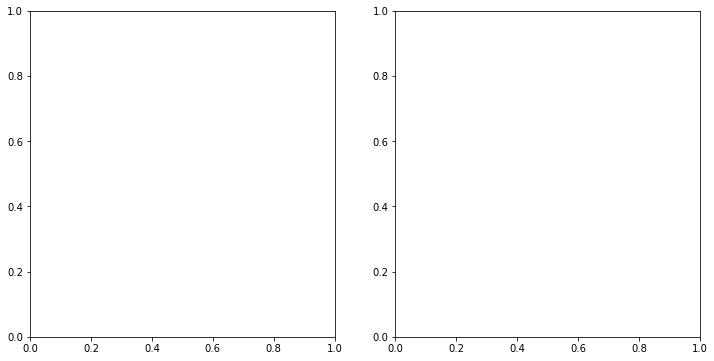

In [9]:
'''
Plot of the residual data
'''
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))


ax[0].plot(iteration_list, df_list_max)
ax[0].plot(iteration_list, df_list_min)
ax[0].set_yscale('log')

#ax[1].plot(iteration_list, res_list)
#ax[1].plot(iteration_list, dHNdA_list_min)



ax[0].set_title('absolute for df')
ax[1].set_title('Residuals for df')

fig.savefig('Residuals_with_volume.png')

In [10]:
plot_polyscope(HC)

NameError: name 'HC' is not defined

In [ ]:
'''
Old version


def b_disc_angle(v, r, print_out=True):
    """
    Takes boundary vertex v and outputs the contact angle

    v: vertex
    N: normal vector estimating the direction of the surface (liquid to gas)
    """

    # Compute the curvature and the dual areas
    F, nn = vectorise_vnn(v)
    c_outd = b_curvatures_hn_ij_c_ij_play(F, nn)

    K_H_i = c_outd['K_H_i']


    #TODO: Adjust for other geometric approximations:
    #l_a = 2 * np.pi * r / len(bV)  # arc length
    Xi = 1
    # Gauss-Bonnet: int_M K dA + int_dM kg ds = 2 pi Xi
    # NOTE: Area should be height of spherical cap    # h = R - r * 4np.tan(theta_p)
    # Approximate radius of the great shpere K = (1/R)**2:
    #r =  #TODO: test if this is a good approximation
    R_approx = 1 / np.sqrt(K_H_i)
    theta_p_approx = np.arccos(np.min([r / R_approx, 1]))
    h = R_approx - r * np.tan(theta_p_approx)
    A_approx = 2 * np.pi * R_approx * h  # Area of spherical cap

    # A_approx  # Approximate area of the spherical cap
    kg_ds = 2 * np.pi * Xi - K_H_i * (A_approx)
    ds = 2 * np.pi * r  # Arc length of whole spherical cap
    k_g = kg_ds / ds  # / 2.0
    phi_est = np.arctan(R_approx * k_g)

    if print_out:
        print(f'theta_p_approx = {theta_p_approx * 180 / np.pi}')

    return phi_est
'''